In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from bsi_sentiment.twitter import search_tweets_sn

In [2]:
# sample query
tweets = search_tweets_sn(
  q="iphone",
  since="2012-08-01",
  until="2012-11-30",
  lang="en",
  max_tweets=100
)

In [3]:
tweet = tweets.__getitem__(0)
tweet

{'id': 274301714927071235, 'permalink': 'https://twitter.com/WilliamBilliot/status/274301714927071235', 'username': 'WilliamBilliot', 'text': "I've harvested 1,120 of food! http://t.co/ckQOrrzp #iphone, #iphonegames, #gameinsight", 'date': '2012-11-29'}

This is an example of a tweet that we do not want...probably have to do some kind of filtering to collect the relevant tweets only 

For now, I'll just try doing it by filtering out tweets that contain links.  
https://developer.twitter.com/en/docs/tutorials/building-high-quality-filters

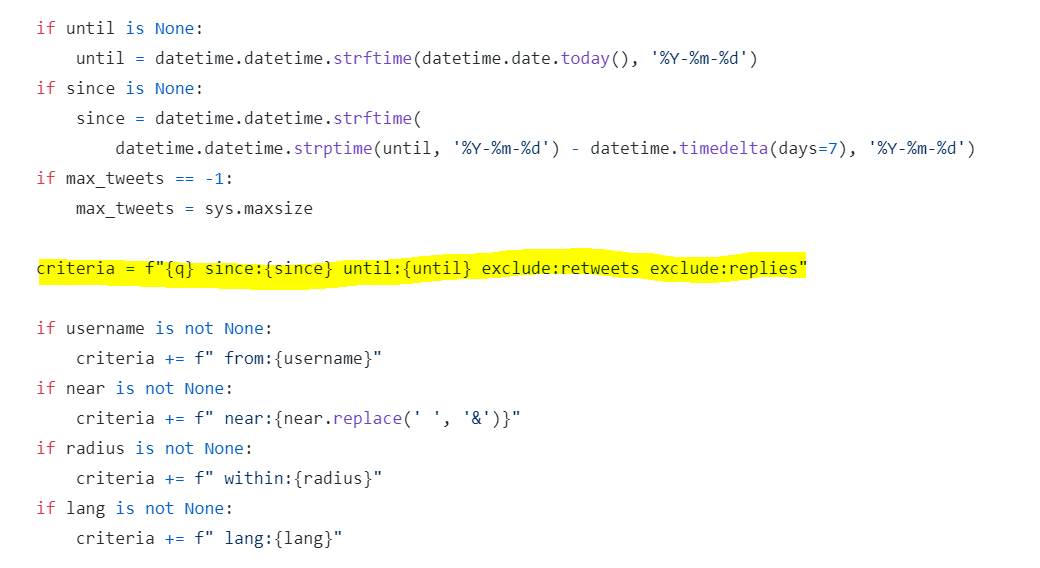

from: https://github.com/BSI-Bocconi/bsi-sentiment/blob/master/bsi_sentiment/twitter.py

In [4]:
# helper function
def convert_date_to_str(date, date_format='%Y-%m-%d'):
    try:
        date_str = date.strftime(date_format)
    except AttributeError:
        print('please enter valid format')
    return date_str

def get_tweets_df(query, start, end, lang='en', max_tweets=1000, near=None, radius=None):
    '''
    query: str
        the search query we want to perform
    start, end: str or datetime
        start and end of time range we are searching for, YYYY-MM-DD
    '''
    if type(start)!=str:
        start = convert_date_to_str(start)
    
    if type(end)!=str:
        end = convert_date_to_str(end)

    # get tweets using lib
    tweets = search_tweets_sn(
        q=query, since=start, until=end, near=near, radius=radius, lang=lang, max_tweets=max_tweets)
    
    # convert to dataframe
    df_dict = {'date': [], 'text': []}
    for t in tweets.tweets:
        df_dict['date'].append(t.date)
        df_dict['text'].append(t.text)
    
    df = pd.DataFrame.from_dict(df_dict)
    return df

phones_df = get_tweets_df('iPhone -filter:links', start='2018-10-01', end='2018-10-30')

In [5]:
phones_df['text'].sample().values

array(['I really cannot wait for my new iPhone because this one really is on its last dying leg!!'],
      dtype=object)

In [6]:
get_tweets_df('macbook -filter:links', start=dt.date(2018, 10, 1), end=dt.date(2018, 10, 14))

,date,text
0,2018-10-13,It be your own macbook hahahahaha
1,2018-10-13,If someone with a cat card wants to come w me ...
2,2018-10-13,A Macbook Is Next Up On My List
3,2018-10-13,I just realized that I have bootcamp on my Mac...
4,2018-10-13,I lowkey want a new MacBook
...,...,...
995,2018-10-11,"Bought a Macbook yesterday, got over $300 off ..."
996,2018-10-11,I’ll be able to buy magic mouse for my MacBook...
997,2018-10-11,Next week I should have my MacBook 😌 new begin...
998,2018-10-11,How many retweet’s for the MacBook Pro 13- inc...


In [7]:
for x in phones_df['text'].values[:20]:
    print(x)
    print('\n')

I swear i want a iPhone with a galaxy look.


Camera Comparison: iPhone XR vs. iPhone XS Max. I Hate Everything.


new iphone got a camera that doesn’t take videos it take #footages


Got the newest iPhone and my whatsapp is loading for three hours🤦🏼‍♂️ haha maybe I should delete some messages I guess haha! LM


Her: “Unlock Yo Phone” 

Me: Alexa Reset IPhone 😭😭😭


this new iphone screentime is scary to look at


My iPhone camera quality resembles pictures from my old sidekick 🙅🏽‍♂️


My Battery On This Dumb Ass IPhone Is Fried .. Shit Charge Slow As Hell &amp;&amp; Die Quick Af .. More Of a Reason To Go Get a New Damn Phone ..


Anybody else wanna know why Cardi B got an iPhone 7 Plus ? Am I the only one who noticed that ? Lol


Find it well creepy how I was having a convo earlier about having a new iPhone and now my Facebook and insta are full of ad’s for the new I phones


I have an iPhone 8 plus and pressing the home button when it’s off kind of feels like biting into a fork by acc

Probably need to clean up the hashtags and next line tokens. 

I think there should be some sentiment analysis tools that can handle emojis

#### VADER sentiment analysis

In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()
scores = [analyser.polarity_scores(x) for x in phones_df['text']]
compound_scores = [x['compound'] for x in scores]
phones_df['scores'] = pd.Series(compound_scores, index=phones_df.index)
phones_df.head()

,date,text,scores
0,2018-10-29,I swear i want a iPhone with a galaxy look.,0.0258
1,2018-10-29,Camera Comparison: iPhone XR vs. iPhone XS Max...,-0.5719
2,2018-10-29,new iphone got a camera that doesn’t take vide...,0.0000
3,2018-10-29,Got the newest iPhone and my whatsapp is loadi...,0.7424
4,2018-10-29,Her: “Unlock Yo Phone” \n\nMe: Alexa Reset IPh...,-0.8519


In [9]:
phones_df.shape

(1000, 3)

In [10]:
# scoring rules:
# positive: x >= 0.05,
# netural: -0.05 < x < 0.05
# negative: x <= -0.05


phones_df['sentiment'] = np.where(phones_df['scores'] >= 0.05, 1,
                              np.where(phones_df['scores'] <= -0.05, -1, 0))

phones_df['sentiment'].value_counts(normalize=True)

 1    0.425
 0    0.300
-1    0.275
Name: sentiment, dtype: float64

In [11]:
def get_sentiment_sample(data, sentiment, n_samples=10):
    '''
    return sample of tweets with the assigned sentiment 
    data: pd.DatFrame,
        should contain 'text' and 'sentiment' column
    sentiment: int, 
        1 = positive
        0 = neutral
        -1 = negative
    n_samples: int,
        the no. of samples u want to take
    '''
    if ('text' not in data.columns) or ('sentiment' not in data.columns):
        print('please make sure you have "text" and "sentiment" columns')
        return
    
    sentiment_mask = data['sentiment'] == sentiment
    sentiment_data = data[sentiment_mask]
    return sentiment_data['text'].sample(n_samples).values

# positive sentiment
for x in get_sentiment_sample(phones_df, 1):
    print(x)
    print('\n')

i hope my iphone cut back on young


My iPhone broke this morning so if you texted or called me I have no idea, but I’m not ignoring you. Hi!


The girl asked if I had a spare phone laying around she could use or something since her iPhone had problems and saw me with my 6 while charging the X. I explained how I might’ve but my storage unit was burglarized so I probably don’t anymore. 😅


Your mcm snorts yay off the back of his iphone 6s every weekend


Retweet for a #Free iPhone 5 will appear in line for a cocc.


The new @oneplus #6T is SEXY. Really considering trading in my iPhone X for it... 🤔 @TMobile @TMobileHelp


torn between buying an iphone or a camera hahahahaha #hirapngproblemako 😂😅


Big props to @NikkiLobczowski who saved my life with advice again today, this time on what to do when the home button on your old AF version iPhone (but brand new replaced via insurance 4 weeks ago) no longer works. Nikki, HOW WILL I EVER SURVIVE WITHOUT YOU 😭


I love my iPhone XS but I just 

In [12]:
# negative sentiment
for x in get_sentiment_sample(phones_df, -1):
    print(x)
    print('\n')

I hate Android so much I got over my fear of joining a cult. I got an iPhone Xr. I feel fine so far; just a little dizzy.


You are using iPhone x, but have you eaten tonight?  😥


I’ve had my iPhone X max for not even a whole week and I already cracked the back of my mf phone y’all 😰


The iPhone, OnePlus, and Pixel phones all ditched the headphone jack this year (ok, Apple did it last year).

2018 is the year the Headphone Jack died.


I would love to get an IPhone again but it’s so overpriced that I am probably going with the new OnePlus 6t. It’s almost 800€ cheaper!!! I mean wtf 800€ price difference is massive!!!


Curly got a iPhone and don’t know how to act... smh @CurlGangCurly


your ex girl chopped &amp; dyed her hair after the break up? ok normal behavior

got some tattoos or piercings? ok also normal behavior 

but if she went from iPhone to an Android ..damn you really did her DIRTY dirty


Now when they ask me...I just reply so...sound like an iPhone. I do not know love, 

In [13]:
# neutral sentiment
for x in get_sentiment_sample(phones_df, 0):
    print(x)
    print('\n')

I’m back. Woke up to a bricked iPhone but I. Am. Back.


i thought wanting an iphone was just a phase but this,, this is not a phase this is a nightmare for my wallet


my iphone restarted abt 10 times in a mf row I JUST WANNA WATCH SANDERS SIDES U C*NT


i dont even have an iphone


The iPhone plus is great... until you drop it on your toe 🤦🏽‍♀️😫


iPhone 8 for sale just has a tiny crack $350 comes with everything


So I kinda wanna switch to iPhone, kinda don't 🤔


How much IPhone 8+ go for in Jamaica these days ?


iPhone X’s max is the moved


Is there a new iPhone coming out? My battery is suddenly dying really fast.




VADER doesn't look like it works the best. Let's just try fitting the time series regression and see what happens anyway. 

### Sales Forecasting

In [28]:
# read data
sales_df = pd.read_excel(r"C:\Users\Timothy Lim\Dropbox\Tim Y4S2\BT4222\Project\apple sales data.xlsx", 
                         sheet_name='Data', engine='openpyxl', usecols="B:E", skiprows=4,
                        names=['Quarter', 'iPhone', 'iPad', 'Mac'])

sales_df.head()

,Quarter,iPhone,iPad,Mac
0,1Q '12,37.04,15.43,5.20
1,2Q '12,35.06,11.80,4.02
2,3Q '12,26.03,17.04,4.02
3,4Q '12,26.91,14.04,4.92
4,1Q '13,47.79,22.86,4.06


In [30]:
sales_df.dtypes

Quarter     object
iPhone     float64
iPad       float64
Mac        float64
dtype: object

In [31]:
sales_df.shape

(28, 4)

In [32]:
sales_df.describe()

,iPhone,iPad,Mac
count,28.000000,28.000000,28.000000
mean,47.218214,13.751071,4.640357
std,14.433032,4.362983,0.611692
min,26.030000,8.920000,3.720000
25%,37.332500,10.310000,4.075000
50%,46.095000,12.850000,4.565000
75%,51.070000,15.602500,5.225000
max,78.290000,26.040000,5.710000


Data represents unit sales of Apple worldwide by product / operating segment.

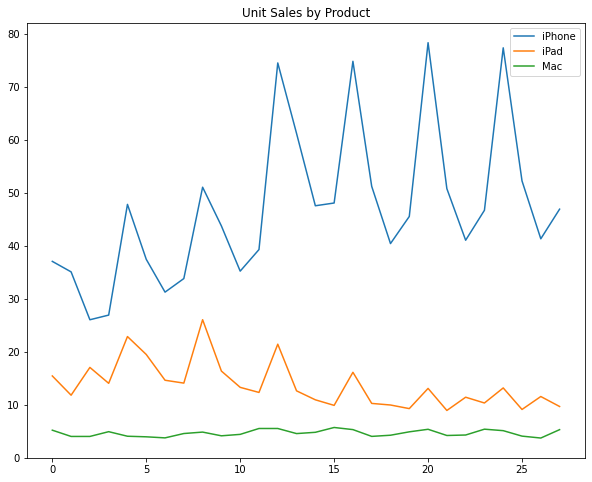

In [45]:
# plot sales
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(10, 8))
axes.plot(sales_df.index, sales_df['iPhone'], label='iPhone')
axes.plot(sales_df.index, sales_df['iPad'], label='iPad')
axes.plot(sales_df.index, sales_df['Mac'], label='Mac')
axes.set_title("Unit Sales by Product")
axes.legend()

plt.show()

C:\Users\Timothy Lim\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


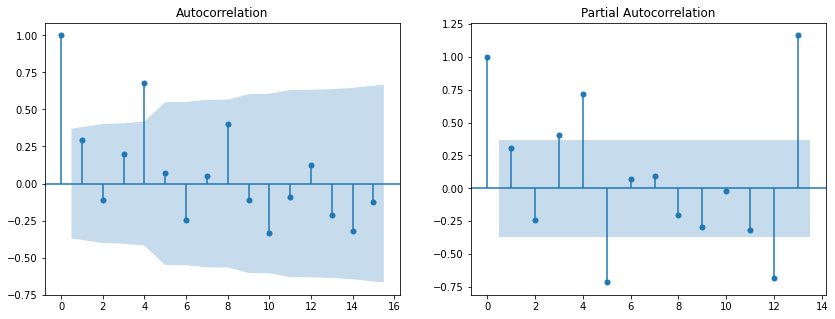

In [64]:
# acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(data):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    plot_acf(data, ax=axes[0])
    plot_pacf(data, lags=13, ax=axes[1])
    plt.show()

# iphone
plot_acf_pacf(sales_df['iPhone'])

C:\Users\Timothy Lim\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


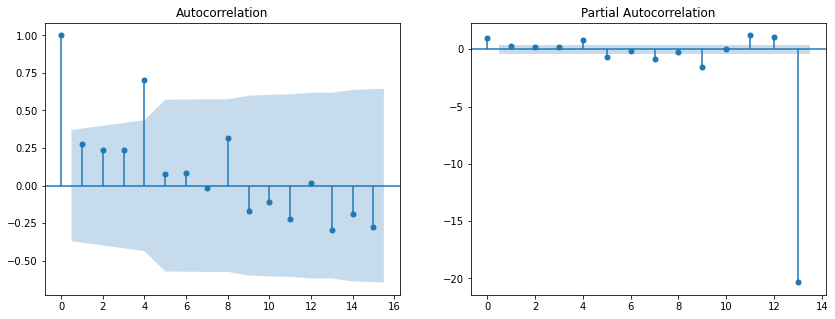

In [65]:
# iPad
plot_acf_pacf(sales_df['iPad'])

C:\Users\Timothy Lim\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


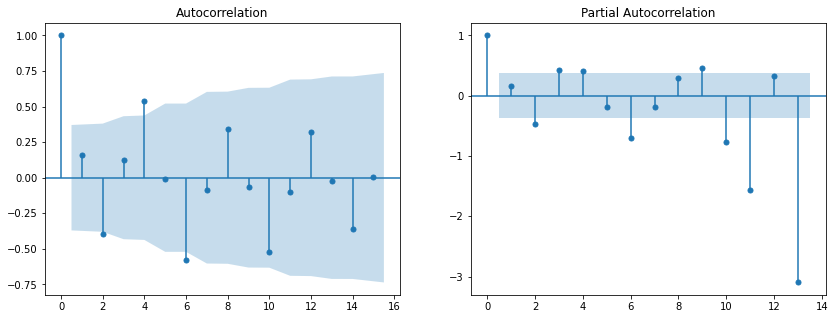

In [66]:
# mac
plot_acf_pacf(sales_df['Mac'])

ACF shows the correlation coefficients between a time series and its lagged values. Useful for identifying the order of MA term. 

PACF isolates the effects of time lag t-n on time t.  Useful for identifying the order of AR term.   
eg. regress y(t) = y(t-1) + y(t-2) + y(t-3), then PACF for time lag 3 is the coefficient of y(t-3). or something like this..

can identify seasonality for all products using the ACF plot, but i'm not sure why lag 13 is significant for all the PACF plots lol 

https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/  

https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/